# San Francisco Crime Data - Exploratory Data Analysis

## Import Libraries & Load Data

In [67]:
import numpy as np 
import pandas as pd 

import os
import time
import datetime
from datetime import datetime

from sklearn.impute import SimpleImputer

import shapefile as shp

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns

import folium
from folium.plugins import HeatMap
from folium.features import DivIcon

from selenium import webdriver

from PIL import Image
from IPython.display import HTML

In [2]:
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv.zip')

sample_submission = pd.read_csv('sampleSubmission.csv.zip')

## General Analysis

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
train_df.shape

(878049, 9)

In [5]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [6]:
test_df.shape

(884262, 7)

The model will need to generalize crime categories based on location information (PdDistrict, Address, X/Y). The model will use training data that includes descriptions, resolutions, and categories of crimes based on location data. Inputs for prediction will be limited to datetime and location information, and the model will need to predict a category of crime.

## Missing Values

In [7]:
train_df.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

## Duplicate Values

In [8]:
train_df.duplicated().sum()

2323

In [9]:
test_df.duplicated().sum()

0

In [10]:
train_df.drop_duplicates(inplace=True)

## Erroneous Values

In [11]:
train_df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
test_df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)

imp = SimpleImputer(strategy='mean')

for district in train_df['PdDistrict'].unique():
    train_df.loc[train_df['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        train_df.loc[train_df['PdDistrict'] == district, ['X', 'Y']])
    test_df.loc[test_df['PdDistrict'] == district, ['X', 'Y']] = imp.transform(
        test_df.loc[test_df['PdDistrict'] == district, ['X', 'Y']])

## Extraneous Features

In [12]:
drop_cols = ['Descript', 'Resolution', 'Id']

for col in drop_cols:
    if col in train_df.columns:
        train_df.drop(col, axis=1, inplace=True)

## Explore Features

### Dates

In [13]:
import time
from datetime import datetime

train_df['Dates'] = train_df['Dates'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [14]:
train_df['Dates'].describe()

count                  875726
unique                 389257
top       2011-01-01 00:01:00
freq                      185
first     2003-01-06 00:01:00
last      2015-05-13 23:53:00
Name: Dates, dtype: object

### DayOfWeek

In [15]:
train_df['DayOfWeek'].value_counts()

Friday       133371
Wednesday    128829
Saturday     126469
Thursday     124757
Tuesday      124603
Monday       121303
Sunday       116394
Name: DayOfWeek, dtype: int64

In [16]:
day_count = train_df['DayOfWeek'].value_counts()

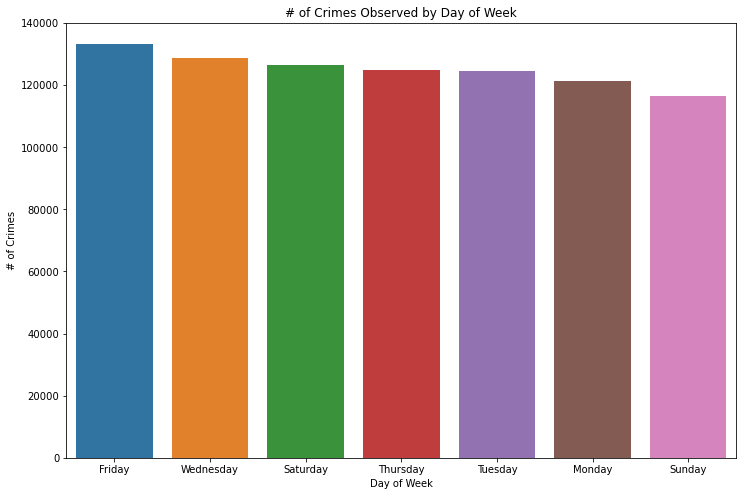

In [17]:
plt.figure(figsize=(12,8))

plt.title('# of Crimes Observed by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('# of Crimes')

sns.barplot(day_count.index, day_count.values)

plt.show()

### Category

In [18]:
train_df['Category'].value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

In [19]:
train_df['Category'].value_counts().shape

(39,)

In [20]:
cat_count = train_df['Category'].value_counts()

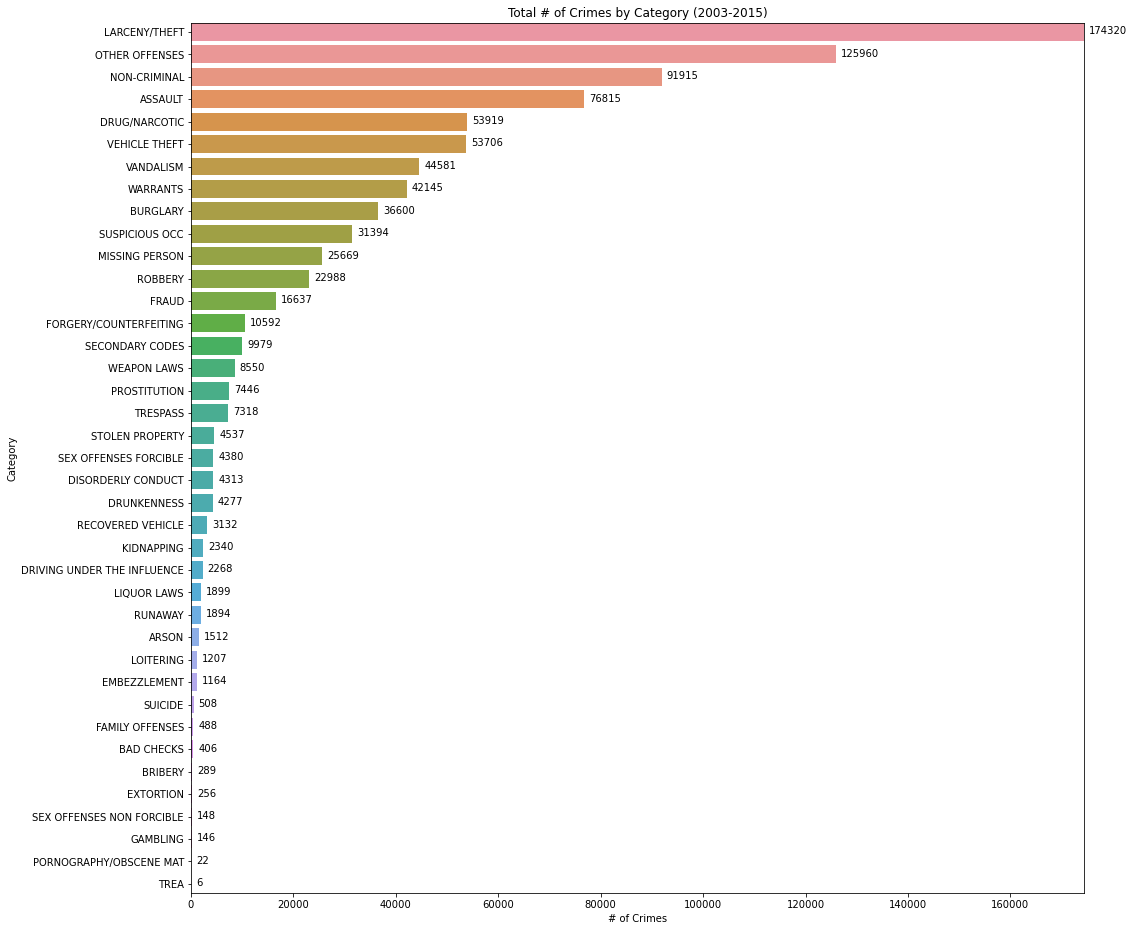

In [21]:
cat_count_df = pd.DataFrame(cat_count)
cat_count_df.reset_index(inplace=True)
cat_count_df.columns = ['Category', 'Count']

plt.figure(figsize=(16,16))




g = sns.barplot(y='Category', x='Count', data=cat_count_df)

# for index, row in cat_count_df.iterrows():
#     g.text(row.Category, row.Count, round(row.Count), color='black', ha='center')

i = 0
for p in g.patches:
    g.text(p.get_width() + 1000, p.get_y() + 0.5, cat_count_df.Count[i])
    i += 1
#     g.annotate(format(p.get_width(), '.1f'), 
#                    (p.get_y() + p.get_height() / 2., p.get_height()), 
#                    ha = 'center', va = 'center', 
#                    xytext = (0, 9), 
#                    textcoords = 'offset points')

# for p in g.patches:
#     g.annotate(p.get_width(), (p.get_y() + p.get_height() / 2., p.get_width()), ha='center', va='center', textcoords='offset points')
plt.margins(0)
plt.title('Total # of Crimes by Category (2003-2015)')
plt.xlabel('# of Crimes')
plt.ylabel('Category')
plt.show()



### PdDistrict

In [22]:
train_df['PdDistrict'].value_counts()

SOUTHERN      156528
MISSION       119723
NORTHERN      105105
BAYVIEW        89098
CENTRAL        85267
TENDERLOIN     81642
INGLESIDE      78722
TARAVAL        65400
PARK           49161
RICHMOND       45080
Name: PdDistrict, dtype: int64

In [23]:
pd_count = train_df['PdDistrict'].value_counts()

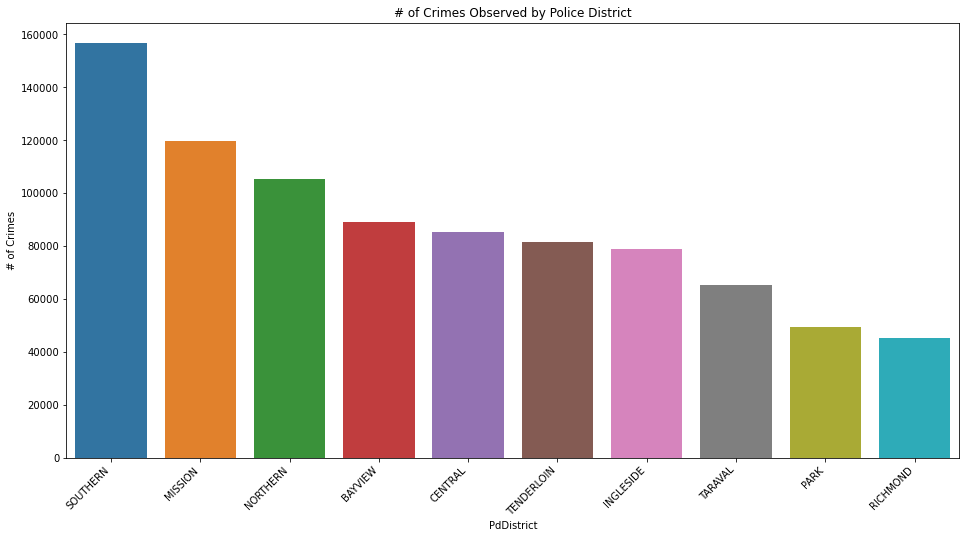

In [24]:
plt.figure(figsize=(16,8))

plt.title('# of Crimes Observed by Police District')
plt.xlabel('PdDistrict')
plt.ylabel('# of Crimes')
plt.xticks(rotation=45, horizontalalignment='right')

sns.barplot(pd_count.index[:20], pd_count.values[:20])

plt.show()

### Address

In [25]:
add_count = train_df['Address'].value_counts()

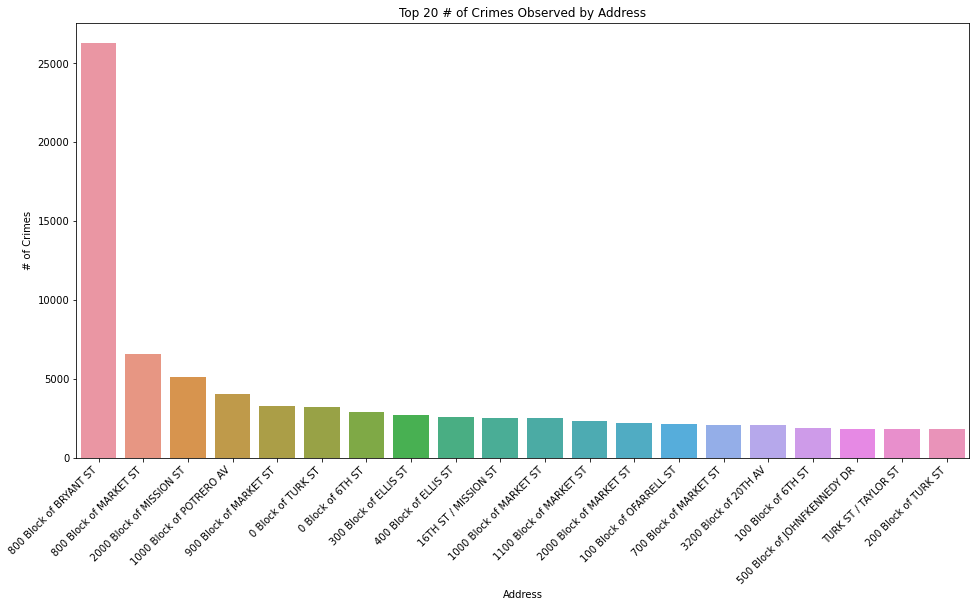

In [26]:
plt.figure(figsize=(16,8))

plt.title('Top 20 # of Crimes Observed by Address')
plt.xlabel('Address')
plt.ylabel('# of Crimes')
plt.xticks(rotation=45, horizontalalignment='right')

sns.barplot(add_count.index[:20], add_count.values[:20])

plt.show()

In [27]:
print('X range: {} - {}'.format(np.min(train_df.X), np.max(train_df.X)))
print('Y range: {} - {}'.format(np.min(train_df.Y), np.max(train_df.Y)))

print('X mean: {}'.format((np.min(train_df.X) + np.max(train_df.X))/2))
print('Y mean: {}'.format((np.min(train_df.Y) + np.max(train_df.Y))/2))

X range: -122.51364206429 - -122.36493749408001
Y range: 37.7078790224135 - 37.819975492297004
X mean: -122.439289779185
Y mean: 37.76392725735525


* 800 Block of Bryant St - -122.40340479147899, 37.775420706711  - Police Department Investigations, Traffic Court, Probation Department, Jail, Hall of Justice
* -122.41965834371, 37.7642205603745 - 2050 Mission St., Buy Sell Loan - Pawn Shop
* -122.406539115148, 37.7564864109309 - Portero Ave. and 22nd St. - San Francisco General Hospital
* -122.407633520742, 37.7841893501425 - Westfield San Francisco Centre (shopping center)
* 

# Bar Chart Race by  Year

In [33]:
def process_dates(df):
    
    df['Year'] = df['Dates'].apply(lambda x: x.year)
    df['Month'] = df['Dates'].apply(lambda x: x.month)
    df['Day'] = df['Dates'].apply(lambda x: x.day)
    df['Hour'] = df['Dates'].apply(lambda x: x.hour)
    df['Minute'] = df['Dates'].apply(lambda x: x.minute)
    df['Special Time'] = df['Minute'].isin([0,30]).astype(int)
    df['Date_only'] = df['Month'].astype(str) + '-' + df['Day'].astype(str) + '-' + df['Year'].astype(str) 
    df['Date_only'] = df['Date_only'].apply(lambda x: datetime.strptime(x, '%m-%d-%Y'))
    
    df['Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x == 'Saturday' or x == 'Sunday' else 0)
    df['Night'] = df['Hour'].apply(lambda x: 1 if x > 6 and x < 18 else 0)
    
    
    return df

In [34]:
train_df = process_dates(train_df)

In [45]:
year_counts = train_df.groupby(['Year', 'Category']).count().reset_index().pivot(index='Year', columns='Category', values='DayOfWeek')
year_counts.fillna(0, inplace=True)

In [46]:
def style_axes(ax):
    ax.set_facecolor('0.8')
    ax.tick_params(labelsize=5, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]

In [47]:
def prepare_data(df, steps=20):
    df = df.reset_index()
    df.index = df.index * steps
    last_idx = df.index[-1] + 1
    df_expanded = df.reindex(range(last_idx))
    df_expanded['Year'] = df_expanded['Year'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('Year')
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_expanded = df_expanded.interpolate()
    df_rank_expanded = df_rank_expanded.interpolate()
    return df_expanded, df_rank_expanded

df_expanded, df_rank_expanded = prepare_data(year_counts)

In [48]:
labels = df_expanded.columns
colors = plt.cm.Dark2(range(6))

In [49]:
def init():
    ax.clear()
    style_axes(ax)
#     ax.set_ylim(min(y_pos)-1, max(y_pos+1))

def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i]
    ax.set_ylim(min(y) - 1, max(y) + 1)
    ax.set_title(f'San Francisco Crimes by Category - {int(date_str)}', fontsize='smaller')
    ax.set_xlabel('# of Crimes')
    
fig = plt.Figure(figsize=(8, 8), dpi=144)
ax = fig.add_subplot()
fig.subplots_adjust(left=0.2)
anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

In [50]:
html = anim.to_html5_video()
HTML(html)

In [51]:
anim.save('bar_chart_race.mp4', writer='ffmpeg', fps=10, dpi=144, bitrate=1800, metadata={'title':'SF Crime Bar Chart Race'})

# Heat Map - Category

In [52]:
district_labels = {
    'SOUTHERN': '37.774432, -122.401121',
    'BAYVIEW': '37.734332, -122.389920',
    'MISSION': '37.756478, -122.423663',
    'NORTHERN': '37.787740, -122.430300',
    'TENDERLOIN': '37.781980, -122.412981',
    'CENTRAL': '37.796200, -122.409293',
    'PARK': '37.765352, -122.449282',
    'RICHMOND': '37.776204, -122.483285',
    'INGLESIDE': '37.726817, -122.437207',
    'TARAVAL': '37.737775, -122.484375'
}

In [53]:
mean_lat = np.mean(train_df.X)
mean_lon = np.mean(train_df.Y)

sw = train_df[['Y', 'X']].min().values.tolist()
ne = train_df[['Y', 'X']].max().values.tolist()

In [54]:
train_df['Coordinates'] = train_df['X'].astype(str) + ', ' + train_df['Y'].astype(str)

In [55]:
train_df.Coordinates.value_counts()[:5]

-122.40340479147899, 37.775420706711    26066
-122.41965834371, 37.7642205603745       4447
-122.406539115148, 37.7564864109309      3875
-122.407633520742, 37.7841893501425      3168
-122.419671780296, 37.7650501214668      3001
Name: Coordinates, dtype: int64

The most common coordinate pair (-122.40340479147899, 37.775420706711) is the location of the Hall of Justice. In many cases, crimes are charged at the courthouse. In these cases, the location where the crime occurred is not available. Since this location skews the distribution of points heavily, we will remove crimes reported at this location when generating a heat map to visualize how each category of crime is distributed across the city. It's important to keep these points included with the training data though since some categories of crime may be far more likely to be charged at the courthouse than others.

In [56]:
if os.path.isdir('images'):
    pass
else:
    os.mkdir('images')

In [57]:
# Import Police Department District Borders
district_outlines = 'districts.geojson'

In [58]:
def create_cat_df(cat, df):
    cat_df = df[df.Category == cat]
    cat_df = cat_df.groupby('Coordinates').count().reset_index()
    cat_df['X'] = cat_df.Coordinates.apply(lambda x: float(x.split(",")[0]))
    cat_df['Y'] = cat_df.Coordinates.apply(lambda x: float(x.split(",")[1]))
    cat_df = cat_df[['X', 'Y', 'DayOfWeek']]
    cat_df.columns = ['X', 'Y', 'Count']
    max_count = float(np.max(cat_df.Count.values))
    return cat_df, max_count

def create_map(x, y, counts):
    hmap = folium.Map(location=[mean_lon, mean_lat], zoom_start=12)

    hm_wide = HeatMap(list(zip(Y_coords, X_coords, counts)),
                      min_opacity=0.2, 
                      max_val=max_count,
                      radius=17, 
                      blur=15,
                      max_zoom=1)

    folium.GeoJson(
        district_outlines,
        style_function = lambda x: {'opacity':1,
                                    'weight':1,
                                    'color': '#000000',
                                    'fillColor': '#00FFFFFF'},
        tooltip=folium.GeoJsonTooltip(
            fields=['district'],
            localize=True
        ),
        name='geojson'
    ).add_to(hmap)
    
        
    
    hmap.add_child(hm_wide)
    
    for district in train_df.PdDistrict.unique():
        coords = district_labels[district]
        x_coord = float(coords.split(',')[0]) + 0.003
        y_coord = float(coords.split(',')[1]) - 0.005
        
        folium.Marker(
            [x_coord, y_coord],
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=(0,0),
                html='<div style="font-size: 8pt"><strong>%s<strong></div>' % district)
            ).add_to(hmap)

    hmap.fit_bounds([sw, ne])
    
    delay = 5

    #Save the map as an HTML file
    fn='tempmap.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    hmap.save(fn)

    #Open a browser window...
    browser = webdriver.Firefox()
    #..that displays the map...
    browser.get(tmpurl)
    #Give the map tiles some time to load
    time.sleep(delay)
    #Grab the screenshot
    if "/" in cat:
        cat_name = cat.replace('/', '-')
    else:
        cat_name = cat
    browser.save_screenshot('images/{}.png'.format(cat_name))
    #Close the browser
    browser.quit()

In [59]:
for cat in train_df.Category.unique():
    cat_df, max_count = create_cat_df(cat, train_df)
    
    X_coords = [float(x) for x in cat_df.X.values]
    Y_coords = [float(x) for x in cat_df.Y.values]
    counts = [float(x) for x in cat_df.Count.values]
    create_map(X_coords, Y_coords, counts) 

# Heat Map - Category (Hall of Justice Removed)

In [60]:
hoj_coord = train_df.Coordinates.value_counts().index[0]

In [61]:
train_nohoj = train_df[train_df.Coordinates != hoj_coord]

In [62]:
for cat in train_nohoj.Category.unique():
    cat_df, max_count = create_cat_df(cat, train_nohoj)
    
    X_coords = [float(x) for x in cat_df.X.values]
    Y_coords = [float(x) for x in cat_df.Y.values]
    counts = [float(x) for x in cat_df.Count.values]
    create_map(X_coords, Y_coords, counts) 

### Generate Image Grid

In [82]:
image_paths = ['images/' + x for x in os.listdir('images') if 'png' in x ]
image_paths.sort()

label_list = [x.split('.')[0][7:] for x in image_paths]

In [83]:
def plot_images(images, labels):

    fig = plt.figure(figsize = (16, 14))
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0)

    for i in range(3*3):
        if i > 8:
            pass
        else:
            ax = fig.add_subplot(gs[i])

            image = Image.open(images[i])

            ax.imshow(image, aspect=1)
            ax.set_title(labels[i], fontsize=16)
            ax.axis('off')
    
    plt.savefig('images/map_grid.png', bbox_inches='tight')

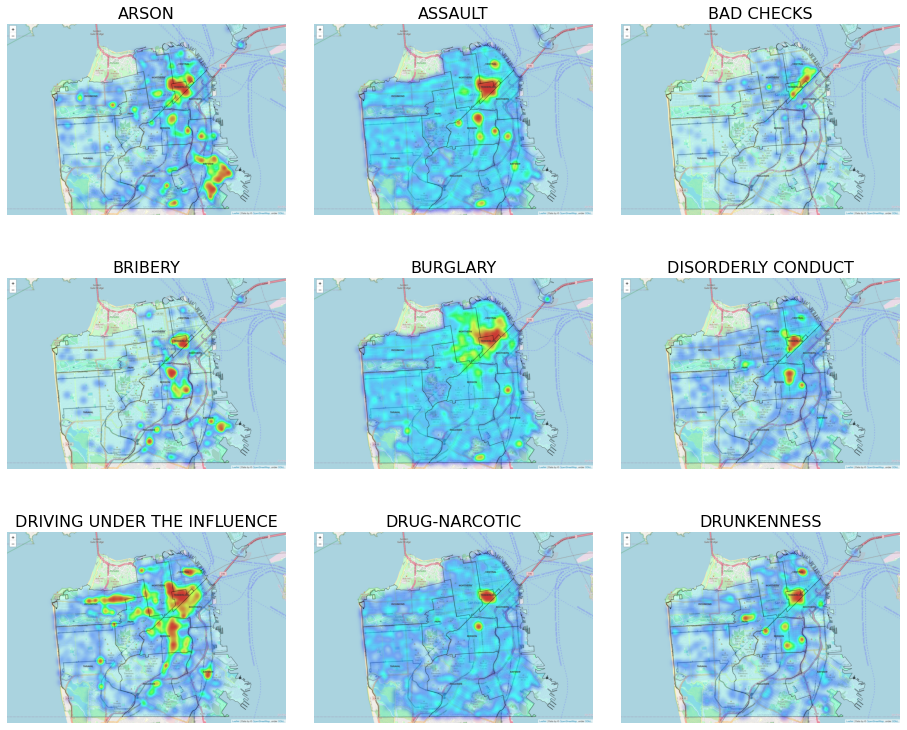

In [84]:
plot_images(image_paths, label_list)